In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import kruskal
from itertools import product
import itertools

In [2]:
df=pd.read_csv("D:\\Desktop\\repos\\Bloom-Filter-Carbon-Footprint\\emissions_bl_gpu_test.csv")

In [3]:
def get_plots(df,col,group='method'):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=col, hue=group, element="step", kde=True)
    plt.title('Histogram')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    plt.show()
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=group, y=col)
    plt.title('Boxplot')
    plt.xlabel(group)
    plt.ylabel(col)
    plt.show()

In [4]:
df['scaled_time'] = np.where(df['running_method'] == 'seq',df['total_time'] * 35, df['total_time'])
df['emission_rate']=df['electricity']/df['total_time']
df.head()

,total_time,electricity,method,running_method,stage,running,scaled_time,emission_rate
0,0.062919,2.442123e-07,bloom_filter,seq,training,gpu,2.202170,0.000004
1,0.055421,3.658300e-07,bloom_filter,seq,training,gpu,1.939722,0.000007
2,0.053014,2.057661e-07,bloom_filter,seq,training,gpu,1.855483,0.000004
3,0.045885,2.231497e-07,bloom_filter,seq,training,gpu,1.605986,0.000005
4,0.060445,4.053901e-07,bloom_filter,seq,training,gpu,2.115577,0.000007


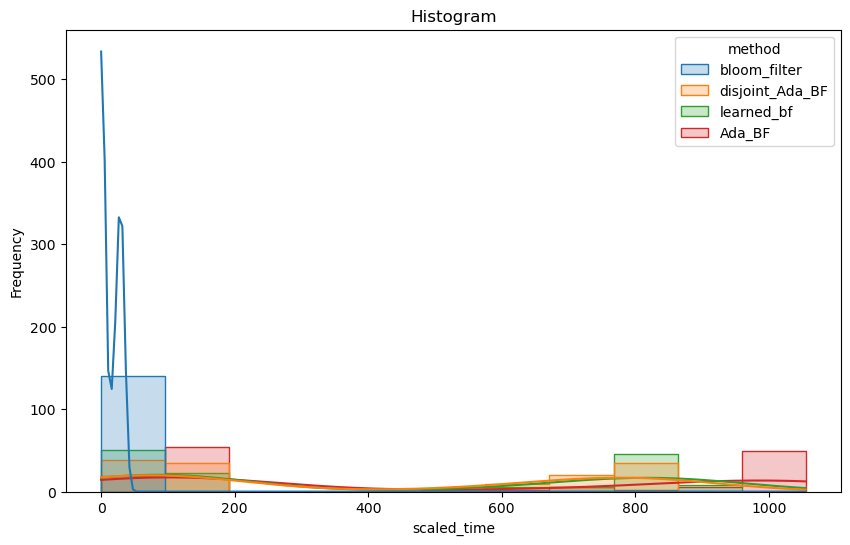

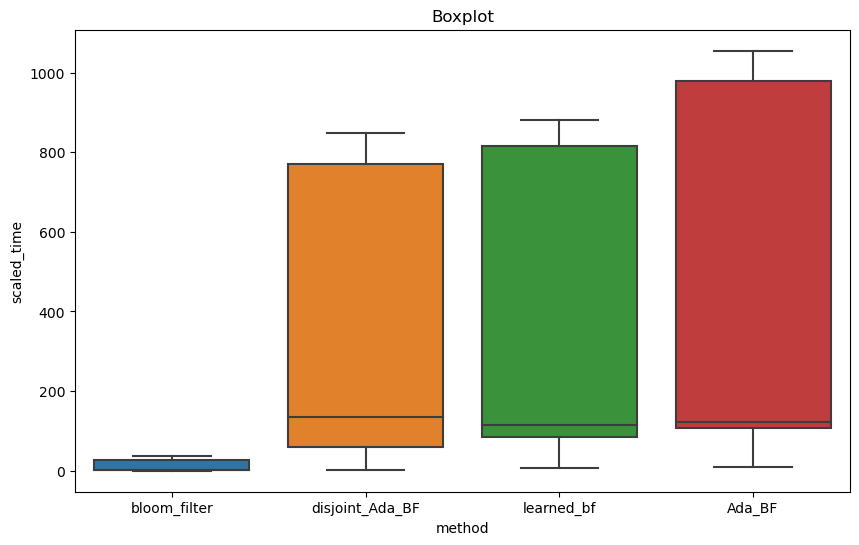

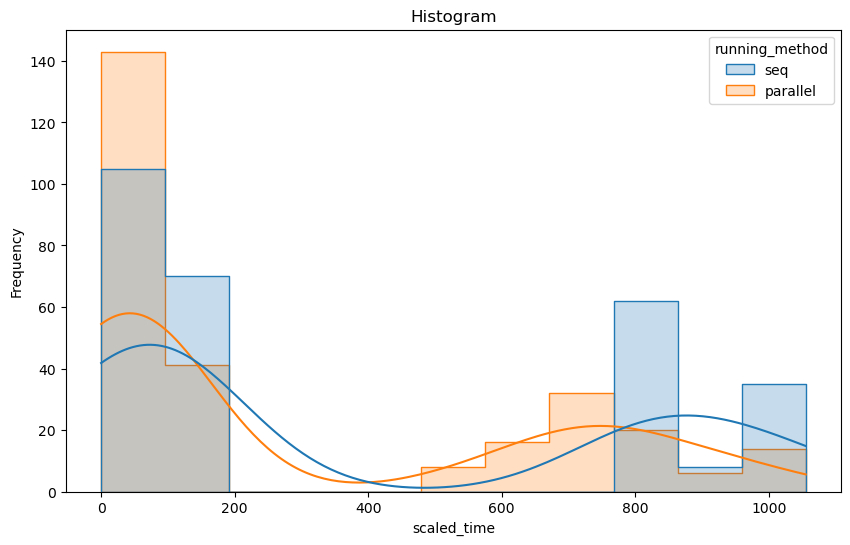

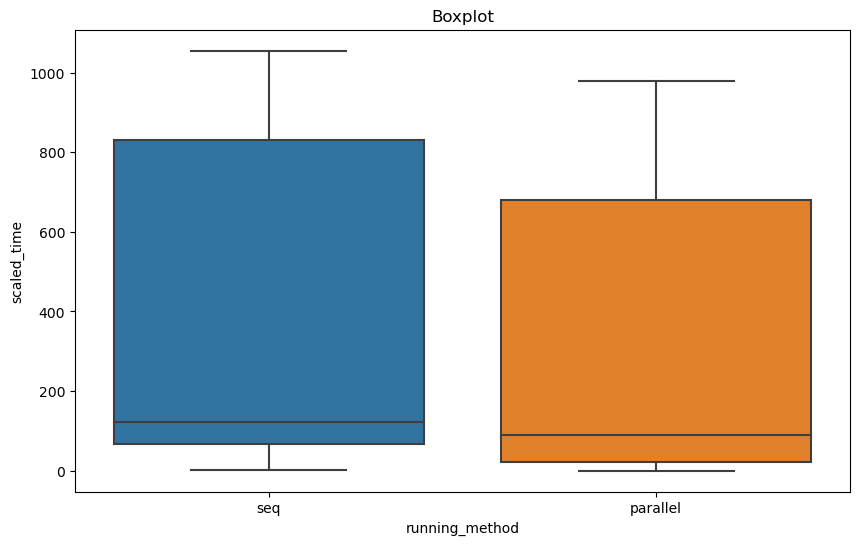

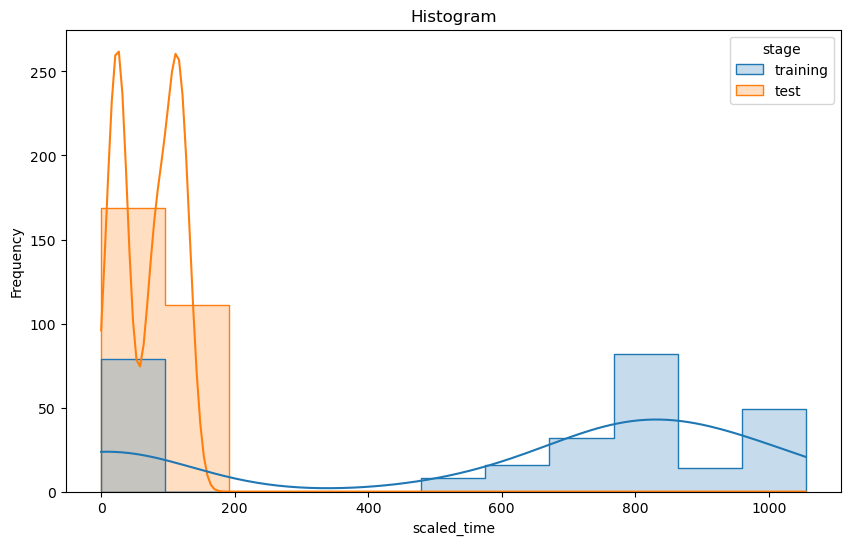

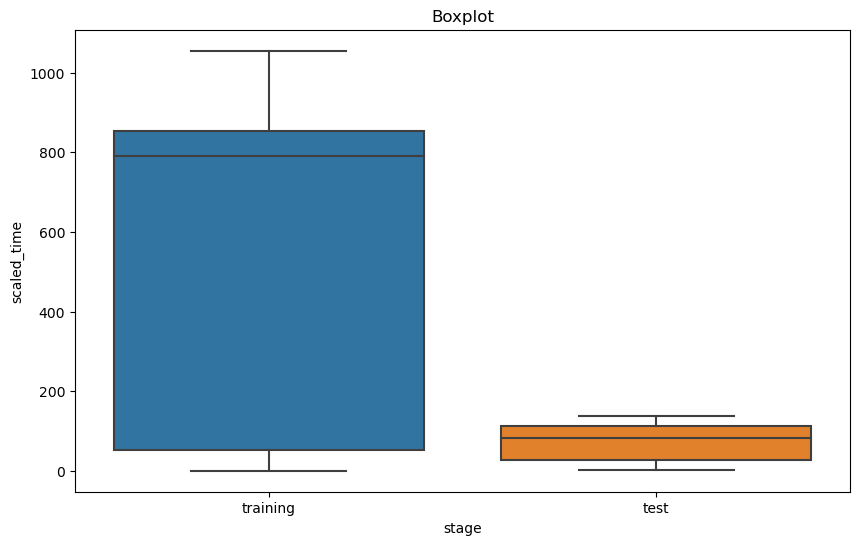

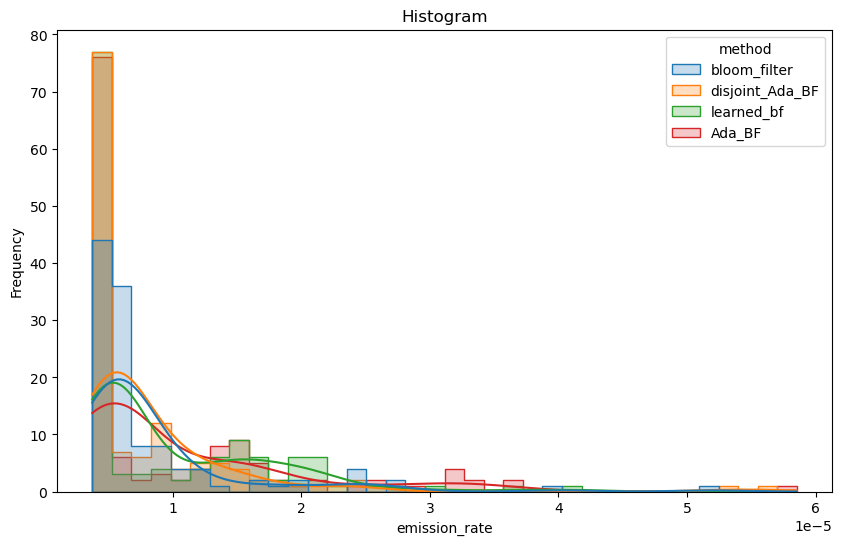

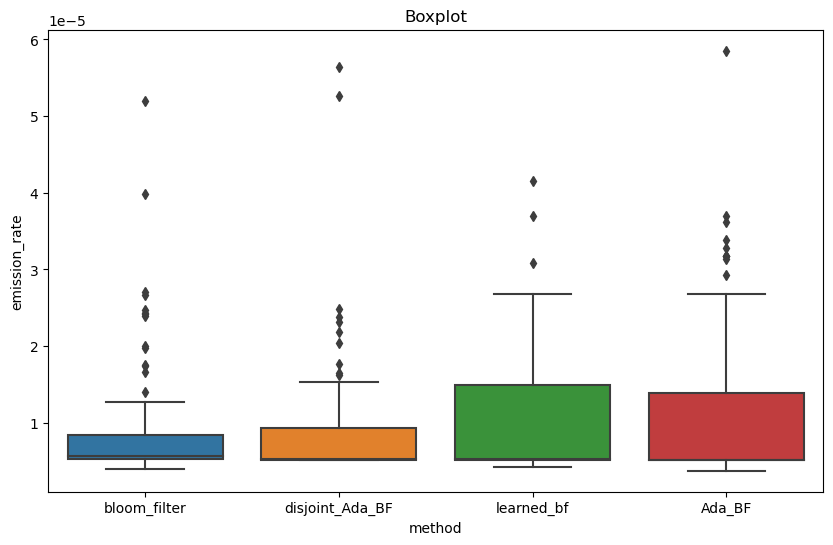

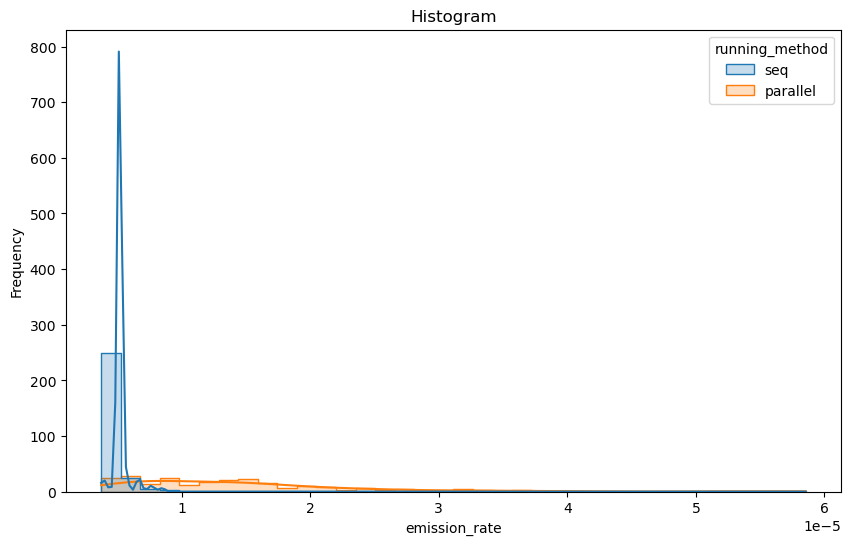

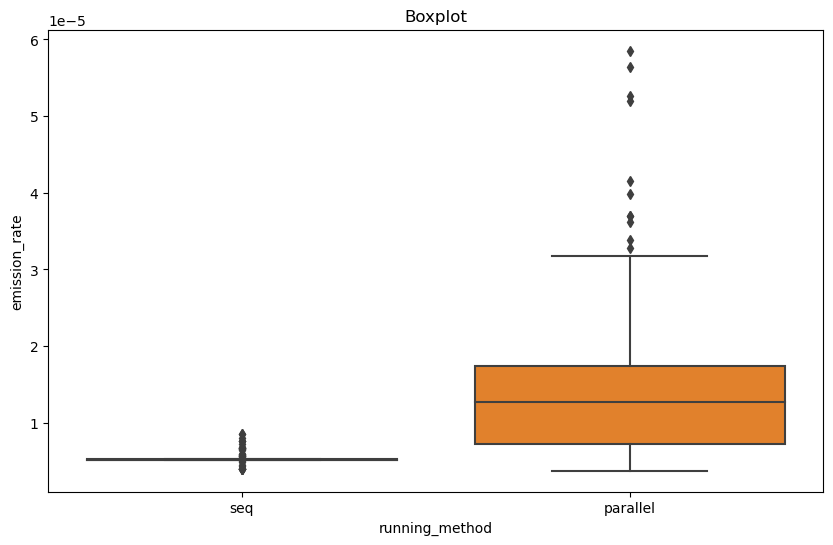

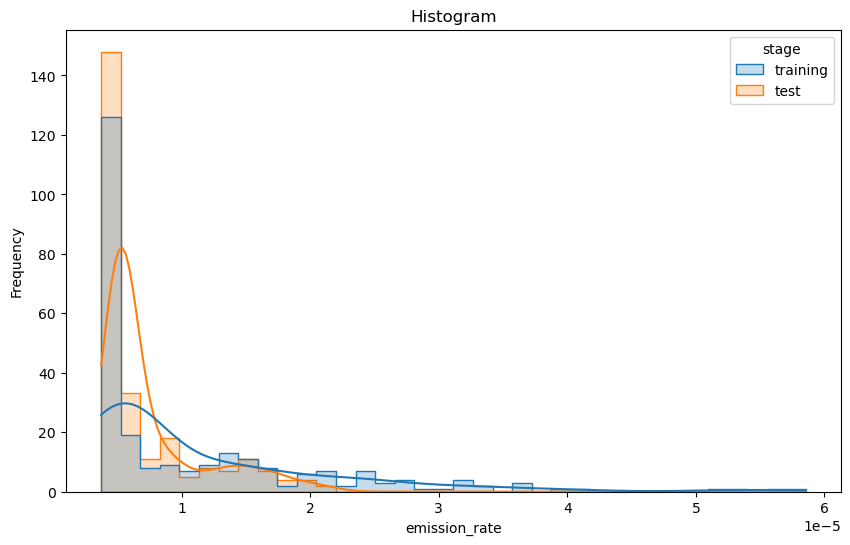

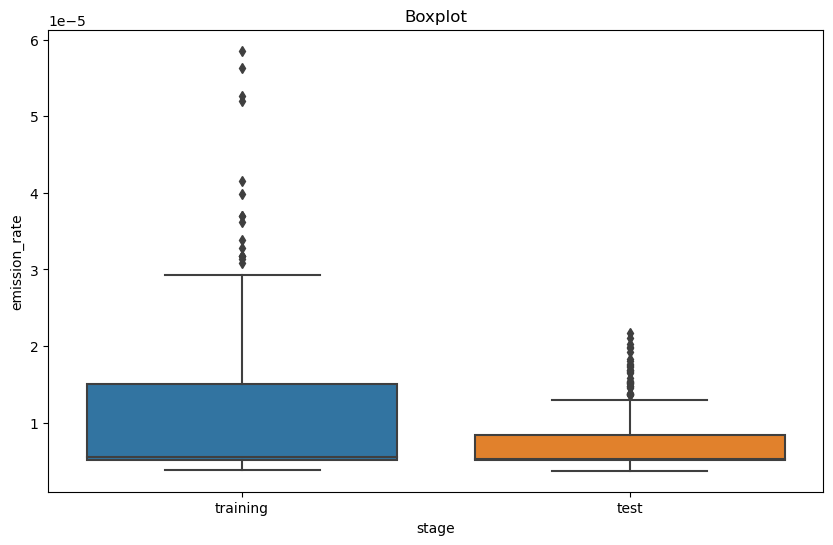

In [5]:
groups=['method','running_method','stage']
cols=['scaled_time','emission_rate']

for col in cols:
    for gr in groups:
        get_plots(df,col,gr)
        

In [6]:
## anova test
model = ols('emission_rate ~ C(method) + C(running_method) + C(stage)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                         sum_sq     df           F        PR(>F)
C(method)          3.352456e-10    3.0    3.120404  2.572731e-02
C(running_method)  1.029226e-08    1.0  287.395289  1.869204e-51
C(stage)           1.937850e-09    1.0   54.111456  7.614872e-13
Residual           1.826422e-08  510.0         NaN           NaN


In [7]:
def anova_with_two_blocking(df, response_var, treatment_var, blocking_var1, blocking_var2):
    formula = f'{response_var} ~ C({treatment_var}) + C({blocking_var1}) + C({blocking_var2}) + \
               C({treatment_var}):C({blocking_var1}) + C({treatment_var}):C({blocking_var2}) + \
               C({blocking_var1}):C({blocking_var2})'
    model = ols(formula, data=df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    return aov_table

In [8]:
print(anova_with_two_blocking(df, 'emission_rate', 'running_method', 'method', 'stage'))

                                   sum_sq     df           F        PR(>F)
C(running_method)            1.034027e-08    1.0  338.198198  3.801467e-58
C(method)                    3.675852e-10    3.0    4.007522  7.759142e-03
C(stage)                     1.962127e-09    1.0   64.175062  7.981937e-15
C(running_method):C(method)  4.833334e-10    3.0    5.269444  1.382187e-03
C(running_method):C(stage)   2.190737e-09    1.0   71.652180  2.825939e-16
C(method):C(stage)           2.871708e-10    3.0    3.130820  2.538226e-02
Residual                     1.537902e-08  503.0         NaN           NaN


In [9]:
print(anova_with_two_blocking(df, 'emission_rate', 'method', 'running_method', 'stage'))

                                   sum_sq     df           F        PR(>F)
C(method)                    3.675852e-10    3.0    4.007522  7.759142e-03
C(running_method)            1.034027e-08    1.0  338.198198  3.801467e-58
C(stage)                     1.962127e-09    1.0   64.175062  7.981937e-15
C(method):C(running_method)  4.833334e-10    3.0    5.269444  1.382187e-03
C(method):C(stage)           2.871708e-10    3.0    3.130820  2.538226e-02
C(running_method):C(stage)   2.190737e-09    1.0   71.652180  2.825939e-16
Residual                     1.537902e-08  503.0         NaN           NaN


In [10]:
print(anova_with_two_blocking(df, 'emission_rate', 'stage', 'method', 'running_method'))

                                   sum_sq     df           F        PR(>F)
C(stage)                     1.962127e-09    1.0   64.175062  7.981937e-15
C(method)                    3.675852e-10    3.0    4.007522  7.759142e-03
C(running_method)            1.034027e-08    1.0  338.198198  3.801467e-58
C(stage):C(method)           2.871708e-10    3.0    3.130820  2.538226e-02
C(stage):C(running_method)   2.190737e-09    1.0   71.652180  2.825939e-16
C(method):C(running_method)  4.833334e-10    3.0    5.269444  1.382187e-03
Residual                     1.537902e-08  503.0         NaN           NaN


In [11]:
print(anova_with_two_blocking(df, 'scaled_time', 'running_method', 'method', 'stage'))
print(anova_with_two_blocking(df, 'scaled_time', 'method', 'running_method', 'stage'))
print(anova_with_two_blocking(df, 'scaled_time', 'stage', 'method', 'running_method'))

                                   sum_sq     df            F         PR(>F)
C(running_method)            1.131884e+06    1.0   115.782557   1.266186e-24
C(method)                    2.020786e+07    3.0   689.033611  2.646259e-185
C(stage)                     3.917512e+07    1.0  4007.298723  6.632462e-254
C(running_method):C(method)  4.024107e+05    3.0    13.721121   1.219073e-08
C(running_method):C(stage)   4.126517e+05    1.0    42.210934   1.844729e-10
C(method):C(stage)           1.475308e+07    3.0   503.040220  8.421609e-157
Residual                     5.347441e+06  547.0          NaN            NaN
                                   sum_sq     df            F         PR(>F)
C(method)                    2.020786e+07    3.0   689.033611  2.646259e-185
C(running_method)            1.131884e+06    1.0   115.782557   1.266186e-24
C(stage)                     3.917512e+07    1.0  4007.298723  6.632462e-254
C(method):C(running_method)  4.024107e+05    3.0    13.721121   1.219073e-08

In [12]:
##Kruskal Wallis test
methods = ['bloom_filter', 'disjoint_Ada_BF', 'learned_bf', 'Ada_BF']
running_methods = ['seq', 'parallel']
stages = ['training', 'test']


def kruskal_wallis_test(df, category, groups):
    data_groups = [df[df[category] == group]['emission_rate'].dropna() for group in groups]
    stat, p = kruskal(*data_groups)
    if np.isnan(stat) or np.isnan(p):
        print(f"Insufficient data or invalid data for {category}")
    else:
        print(f"Kruskal-Wallis test for {category}: H-statistic = {stat:.3f}, p-value = {p:.3f}")

kruskal_wallis_test(df, 'method', methods)
kruskal_wallis_test(df, 'running_method', running_methods)
kruskal_wallis_test(df, 'stage', stages)


Kruskal-Wallis test for method: H-statistic = 4.540, p-value = 0.209
Kruskal-Wallis test for running_method: H-statistic = 268.590, p-value = 0.000
Kruskal-Wallis test for stage: H-statistic = 1.870, p-value = 0.171


In [13]:
def kruskal_wallis_test_with_blocking(df, y,primary_cat, primary_groups, blocking_cat1, blocking_groups1, blocking_cat2, blocking_groups2):
    for block1, block2 in itertools.product(blocking_groups1, blocking_groups2):
        block_df = df[(df[blocking_cat1] == block1) & (df[blocking_cat2] == block2)]
        data_groups = [block_df[block_df[primary_cat] == group][y].dropna() for group in primary_groups]
        
        stat, p = kruskal(*data_groups)
        if np.isnan(stat) or np.isnan(p):
            print(f"Insufficient data or invalid data for {primary_cat} within blocks {block1}, {block2}")
        else:
            print(f"Kruskal-Wallis test for {primary_cat} within blocks {block1}, {block2}: H-statistic = {stat:.3f}, p-value = {p:.3f}")


methods = ['bloom_filter', 'disjoint_Ada_BF', 'learned_bf', 'Ada_BF']
running_methods = ['seq', 'parallel']
stages = ['training', 'test']


kruskal_wallis_test_with_blocking(df, 'emission_rate','method', methods, 'running_method', running_methods, 'stage', stages)



Kruskal-Wallis test for method within blocks seq, training: H-statistic = 37.037, p-value = 0.000
Kruskal-Wallis test for method within blocks seq, test: H-statistic = 37.065, p-value = 0.000
Kruskal-Wallis test for method within blocks parallel, training: H-statistic = 7.833, p-value = 0.050
Kruskal-Wallis test for method within blocks parallel, test: H-statistic = 21.538, p-value = 0.000


In [14]:

kruskal_wallis_test_with_blocking(df, 'emission_rate','running_method', running_methods,'method', methods,  'stage', stages)

kruskal_wallis_test_with_blocking(df, 'emission_rate', 'stage', stages,'method', methods, 'running_method', running_methods)



Kruskal-Wallis test for running_method within blocks bloom_filter, training: H-statistic = 26.199, p-value = 0.000
Kruskal-Wallis test for running_method within blocks bloom_filter, test: H-statistic = 36.786, p-value = 0.000
Kruskal-Wallis test for running_method within blocks disjoint_Ada_BF, training: H-statistic = 32.619, p-value = 0.000
Kruskal-Wallis test for running_method within blocks disjoint_Ada_BF, test: H-statistic = 30.765, p-value = 0.000
Kruskal-Wallis test for running_method within blocks learned_bf, training: H-statistic = 33.617, p-value = 0.000
Kruskal-Wallis test for running_method within blocks learned_bf, test: H-statistic = 40.040, p-value = 0.000
Kruskal-Wallis test for running_method within blocks Ada_BF, training: H-statistic = 30.545, p-value = 0.000
Kruskal-Wallis test for running_method within blocks Ada_BF, test: H-statistic = 37.912, p-value = 0.000
Kruskal-Wallis test for stage within blocks bloom_filter, seq: H-statistic = 5.437, p-value = 0.020
Kruska

In [18]:
df2=pd.read_csv("D:\\Desktop\\repos\\Bloom-Filter-Carbon-Footprint\emissions_dif_dt_bl.csv")
df2 = df2.loc[df2['total_time'] > 0]
df2['scaled_time'] = np.where(df2['running_method'] == 'seq', df2['total_time'] * 35, df2['total_time'])
df2['emission_rate']=df2['electricity']/df2['total_time']
df2.head()

,total_time,electricity,type,running_method,scaled_time,emission_rate
0,0.015595,2.181254e-07,list,seq,0.545832,0.000014
1,0.016144,6.265910e-08,list,seq,0.565025,0.000004
2,0.015220,1.215991e-07,list,seq,0.532697,0.000008
3,0.009006,1.832343e-07,list,seq,0.315211,0.000020
4,0.015507,1.229569e-07,list,seq,0.542736,0.000008


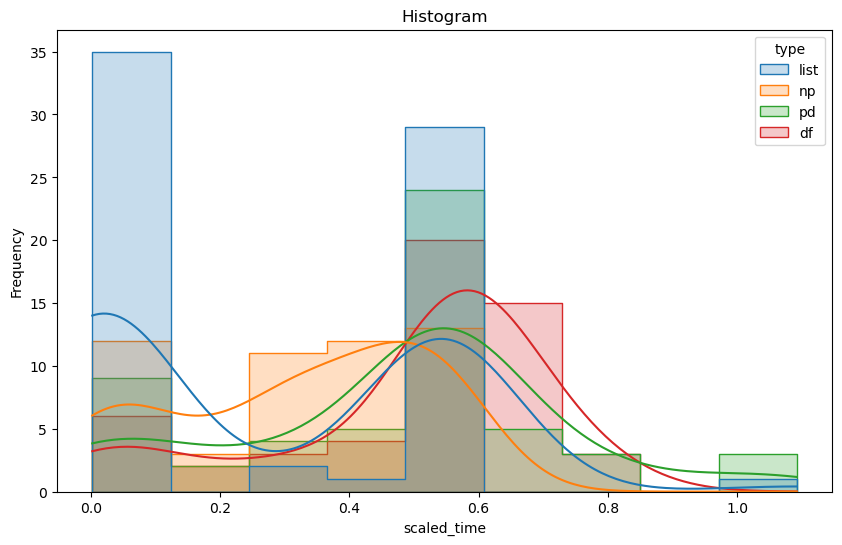

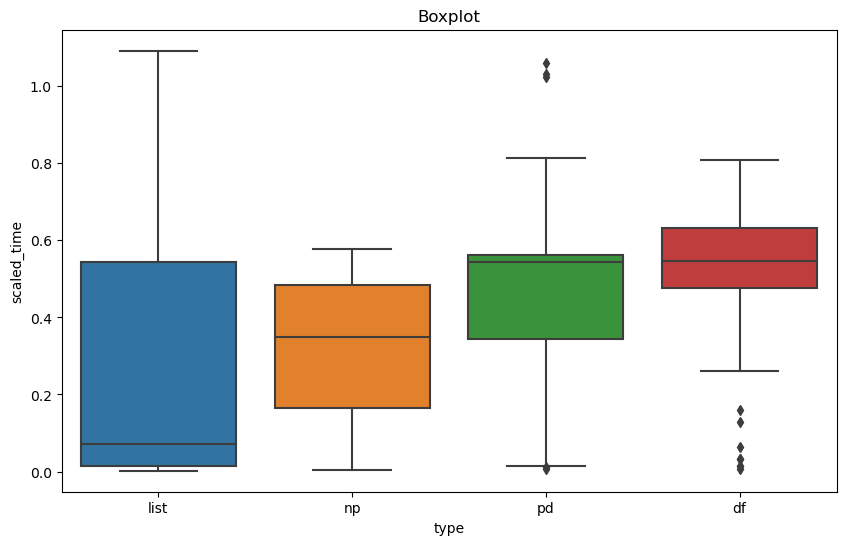

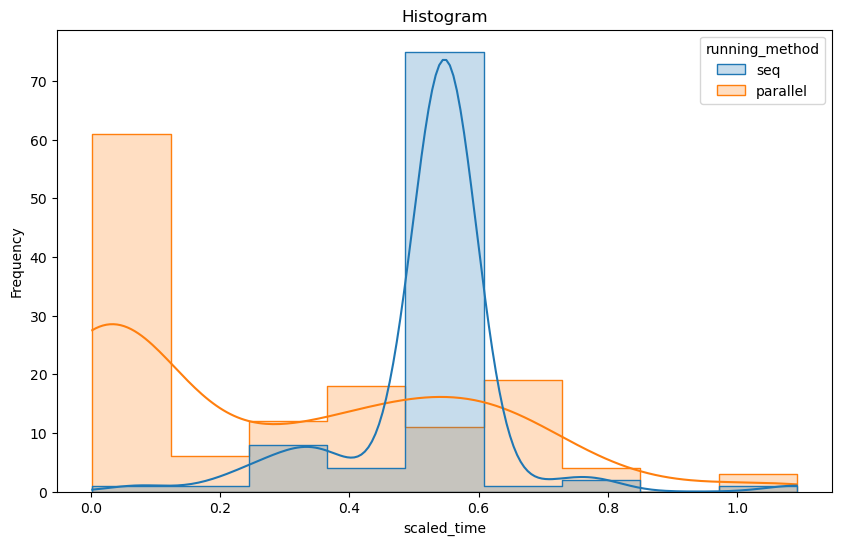

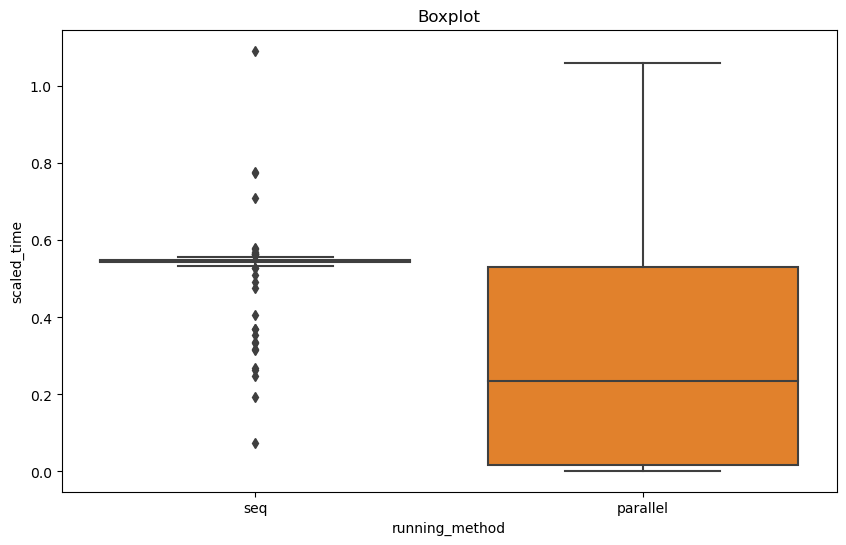

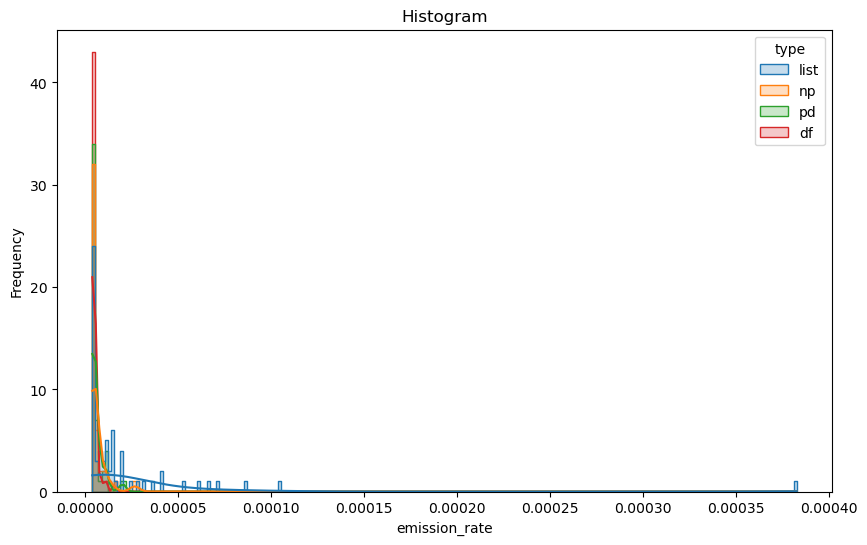

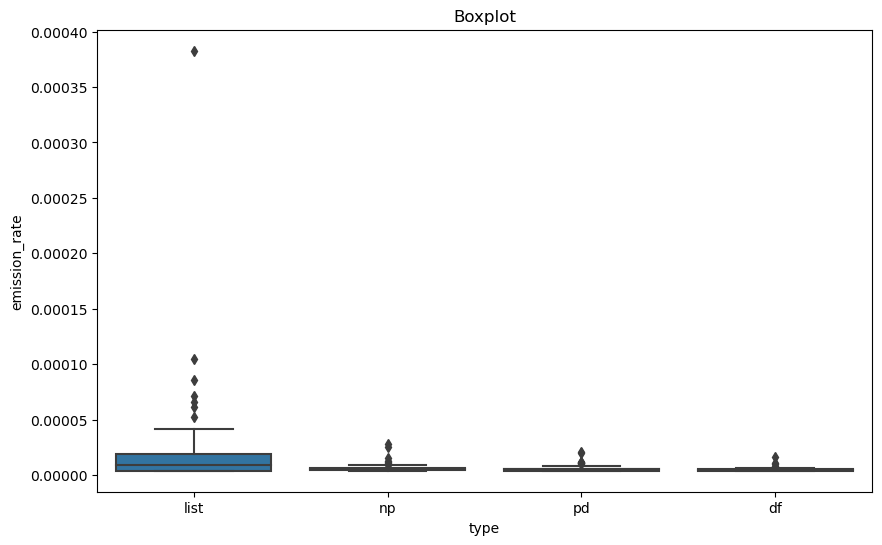

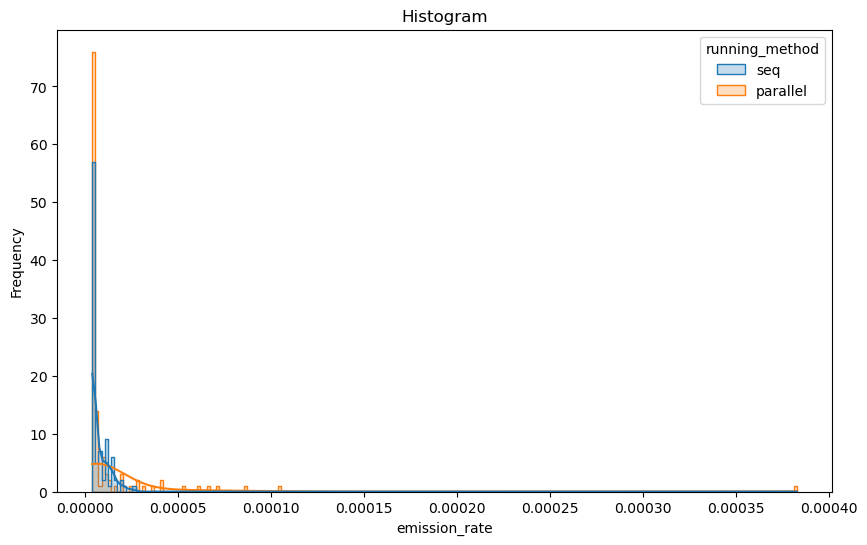

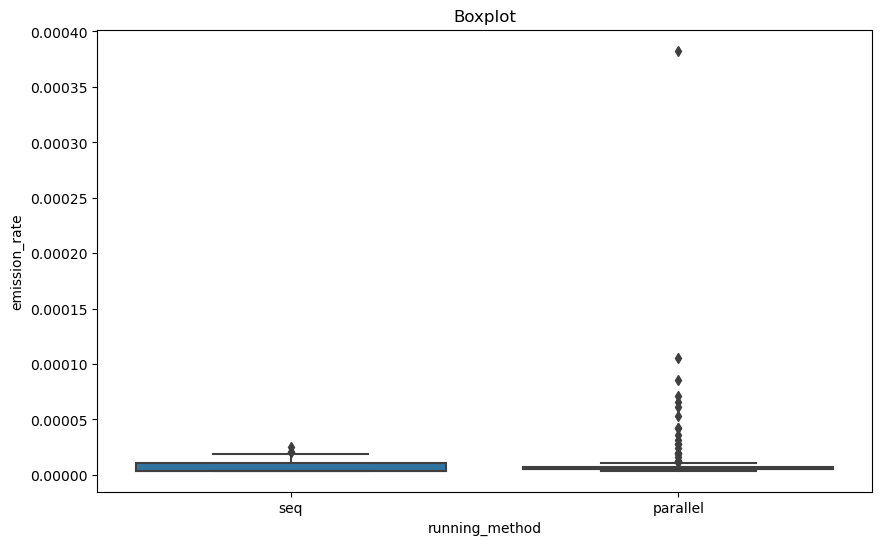

In [19]:
groups=['type','running_method']
cols=['scaled_time','emission_rate']

for col in cols:
    for gr in groups:
        get_plots(df2,col,gr)
        

In [20]:
## anova test
model = ols('emission_rate ~ C(type) + C(running_method)', data=df2).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                         sum_sq     df         F    PR(>F)
C(type)            1.386347e-08    3.0  6.091740  0.000542
C(running_method)  4.075941e-09    1.0  5.373021  0.021423
Residual           1.577875e-07  208.0       NaN       NaN


In [22]:
def anova_with_one_blocking(df, response_var, treatment_var, blocking_var1):
    formula = f'{response_var} ~ C({treatment_var}) + C({blocking_var1}) + C({treatment_var}):C({blocking_var1})'
    model = ols(formula, data=df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    return aov_table

print(anova_with_one_blocking(df2, 'scaled_time', 'running_method', 'type'))
print(anova_with_one_blocking(df2, 'scaled_time', 'type', 'running_method'))

print(anova_with_one_blocking(df2, 'scaled_time', 'running_method', 'type'))
print(anova_with_one_blocking(df2, 'scaled_time', 'type', 'running_method'))

                             sum_sq     df           F        PR(>F)
C(running_method)          3.533375    1.0  101.758988  6.736612e-20
C(type)                    2.547499    3.0   24.455455  1.093354e-13
C(running_method):C(type)  1.871714    3.0   17.968063  1.839671e-10
Residual                   7.604332  219.0         NaN           NaN
                             sum_sq     df           F        PR(>F)
C(type)                    2.547499    3.0   24.455455  1.093354e-13
C(running_method)          3.533375    1.0  101.758988  6.736612e-20
C(type):C(running_method)  1.871714    3.0   17.968063  1.839671e-10
Residual                   7.604332  219.0         NaN           NaN
                             sum_sq     df           F        PR(>F)
C(running_method)          3.533375    1.0  101.758988  6.736612e-20
C(type)                    2.547499    3.0   24.455455  1.093354e-13
C(running_method):C(type)  1.871714    3.0   17.968063  1.839671e-10
Residual                   7.60433

In [24]:
types=df2[ 'type'].unique()

In [25]:

kruskal_wallis_test(df2, 'type', types)
kruskal_wallis_test(df2, 'running_method', running_methods)


Kruskal-Wallis test for type: H-statistic = 18.159, p-value = 0.000
Kruskal-Wallis test for running_method: H-statistic = 15.275, p-value = 0.000


In [26]:
def kruskal_wallis_test_with_one_blocking(df, y, primary_cat, primary_groups, blocking_cat, blocking_groups):
    for block in blocking_groups:
        block_df = df[df[blocking_cat] == block]
        data_groups = [block_df[block_df[primary_cat] == group][y].dropna() for group in primary_groups]
        
        stat, p = kruskal(*data_groups)
        if np.isnan(stat) or np.isnan(p):
            print(f"Insufficient data or invalid data for {primary_cat} within block {block}")
        else:
            print(f"Kruskal-Wallis test for {primary_cat} within block {block}: H-statistic = {stat:.3f}, p-value = {p:.3f}")


kruskal_wallis_test_with_one_blocking(df2,'emission_rate','type',types,'running_method',running_methods)
kruskal_wallis_test_with_one_blocking(df2,'emission_rate','running_method',running_methods,'type',types)

kruskal_wallis_test_with_one_blocking(df2,'scaled_time','type',types,'running_method',running_methods)
kruskal_wallis_test_with_one_blocking(df2,'scaled_time','running_method',running_methods,'type',types)


Kruskal-Wallis test for type within block seq: H-statistic = 6.361, p-value = 0.095
Kruskal-Wallis test for type within block parallel: H-statistic = 18.620, p-value = 0.000
Kruskal-Wallis test for running_method within block list: H-statistic = 9.836, p-value = 0.002
Kruskal-Wallis test for running_method within block np: H-statistic = 1.848, p-value = 0.174
Kruskal-Wallis test for running_method within block pd: H-statistic = 4.334, p-value = 0.037
Kruskal-Wallis test for running_method within block df: H-statistic = 11.806, p-value = 0.001
Kruskal-Wallis test for type within block seq: H-statistic = 6.403, p-value = 0.094
Kruskal-Wallis test for type within block parallel: H-statistic = 59.515, p-value = 0.000
Kruskal-Wallis test for running_method within block list: H-statistic = 50.218, p-value = 0.000
Kruskal-Wallis test for running_method within block np: H-statistic = 14.592, p-value = 0.000
Kruskal-Wallis test for running_method within block pd: H-statistic = 2.608, p-value = 